In [1]:
# %matplotlib ipympl 
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [2]:
# load all data into dataframe
def load_data(path, file_names, aliases):
    dates = {}
    for data_set_idx in range(len(data_files)):
        cur_alias = aliases[data_set_idx]
        with open(path + data_files[data_set_idx] + '.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            spamreader.__next__()
            for row in spamreader:
                try:
                    cur_date = datetime.datetime.strptime(row[0], '%m/%d/%Y')

                except:
                   continue
                if not cur_date in dates:
                    dates[cur_date] = {}
                    # need to generalize here
                if data_set_idx == 0 or data_set_idx == 2:
                    dates[cur_date][cur_alias] = float(row[4])
                elif data_set_idx == 1 or data_set_idx == 3 or data_set_idx == 4 or data_set_idx == 5:
                    dates[cur_date][cur_alias] = float(row[1])

    frame = pd.DataFrame.from_dict(dates, orient='index')
    frame.columns = aliases
    frame.reset_index(inplace=True)
    frame = frame.rename(columns = {'index':'Date'})
    frame = frame.sort_values('Date')
    return frame


In [3]:
# inputs here

path = 'C:\\Users\\plant\\OneDrive\\Documents\\Neural Networks Project\\'

baseline_asset = 'sp'

file_name_SP = 'SandPPrices'  
file_name_RE = 'RealEstateIndexDailySince2013'
file_name_BND = 'isharesBondIndexSince2003'
file_name_EU = 'USD_EURHistoricalData'
file_name_JPY = 'USD_JPYHistoricalData'
file_name_GOLD = 'GoldFuturesHistoricalData'

data_files = [file_name_SP, file_name_RE, file_name_BND, file_name_EU, file_name_JPY, file_name_GOLD]
aliases = ["sp", "re", "bnd", "eu", "jp", "gld"]

frame = load_data(path, data_files, aliases)

In [4]:
frame.iloc[4000: 4050]

,Date,sp,re,bnd,eu,jp,gld
1428,2005-09-08,1231.67,0.8065,110.52,450.7,102.220001,NaN
1429,2005-09-09,1241.48,0.8060,109.70,453.0,102.190002,NaN
1430,2005-09-12,1240.56,0.8143,110.38,453.7,102.050003,NaN
1431,2005-09-13,1231.20,0.8155,110.72,450.0,102.300003,NaN
1432,2005-09-14,1227.16,0.8138,110.36,453.7,102.190002,NaN
1433,2005-09-15,1227.73,0.8182,110.66,459.3,101.940002,NaN
1434,2005-09-16,1237.91,0.8173,111.33,463.3,101.709999,NaN
1435,2005-09-19,1231.02,0.8237,111.53,470.4,101.800003,NaN
1436,2005-09-20,1221.34,0.8254,111.97,470.0,101.730003,NaN
1437,2005-09-21,1210.20,0.8186,111.30,472.6,101.959999,NaN


In [5]:
not_null = frame.query(baseline_asset + ".notnull()")
not_null.reset_index(drop = True, inplace = True)

In [6]:
# adds correlation metrix to dataframe
def add_correlaries(cor_assets, cor_days_out, pred_distance, frame, assets):
    # stores percent changes from past x days 
    cors = [[] for i in range(len(cor_assets))]
    # stores percent changes for x future days for each asset
    futs = {}
    for a in assets:
        futs[a] = []
    
    # iterate through all data points
    for idx, row in frame.iterrows():
        # past data points
        for alias_idx, (asset, days_out) in enumerate(zip(cor_assets, cor_days_out)):
            cur_price = row[asset]
            if idx > days_out: # check for enough data
                # get percent change
                last_time_period = frame.loc[idx - days_out - 1].at[asset]
                time_period_change = (cur_price - last_time_period)/last_time_period
                cors[alias_idx].append(time_period_change)           
            else:
                cors[alias_idx].append(None)
        
        #future data
        for asset in assets:
            cur_price = row[asset]
            if idx + pred_distance < frame.shape[0]:
                fut_val = frame.iloc[idx + pred_distance].at[asset]
                time_period_change = (fut_val - cur_price)/cur_price  
                futs[asset].append(time_period_change)         
            else:
                futs[asset].append(None)
    # input into data frame
    for idx, (asset, days_out) in enumerate(zip(cor_assets, cor_days_out)):
        name = asset + "_" + str(days_out) + "_dys"
        frame.insert(frame.shape[1], name, cors[idx], True)
    
    for asset in futs.keys():
        name = asset + "_fut_" + str(pred_distance) + "dys"
        frame.insert(frame.shape[1], name, futs[asset], True)

In [7]:
def add_pred_differences(pred_distance, assets, frame):
    for idx, asset1 in enumerate(assets):
        for idx2, asset2 in enumerate(assets[idx + 1: ]):
            change1 = frame[asset1 + "_fut_" + str(pred_distance) + "dys"]
            change2 = frame[asset2 + "_fut_" + str(pred_distance) + "dys"]
            diff = change2  - change1
            frame.insert(frame.shape[1], asset2 + "_" + asset1 + "_" + str(pred_distance) + "dys_diff", diff, True)

In [8]:
# input correlaries
cor_assets = ["sp", "re", "bnd", "eu", "jp", "gld", "sp", "re", "bnd", "eu", "jp", "gld", "sp", "re", "bnd", "eu", "jp", "gld", "sp", "re", "bnd", "eu", "jp", "gld"]
cor_days_out = [20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 252, 252, 252, 252, 252, 252, 60, 60, 60, 60, 60, 60]
pred_distance = 10
assets = ["sp", "re", "bnd", "eu", "jp", "gld"]
add_correlaries(cor_assets, cor_days_out, pred_distance, not_null, assets)
add_pred_differences(pred_distance, assets, not_null)

In [89]:
not_null.iloc[5700:5750,[0, 7,8, 9, 10,11,12,13,14,15,16,17,18,19,20]]

,Date,sp_20_dys,re_20_dys,bnd_20_dys,eu_20_dys,jp_20_dys,gld_20_dys,sp_10_dys,re_10_dys,bnd_10_dys,eu_10_dys,jp_10_dys,gld_10_dys,sp_252_dys,re_252_dys
5700,2022-08-29,-0.024134,0.022284,0.041294,-0.018015,-0.028346,-0.041096,-0.058302,0.026270,0.039032,-0.036243,-0.019395,-0.065674,-0.098298,0.175482
5701,2022-08-30,-0.032164,0.024841,0.054555,-0.028752,-0.028591,-0.047335,-0.072369,0.014737,0.041029,-0.034370,-0.019370,-0.082975,-0.116027,0.177775
5702,2022-08-31,-0.033289,0.010472,0.043557,-0.035481,-0.023750,-0.038686,-0.081343,0.011191,0.035392,-0.035481,-0.023181,-0.083225,-0.126698,0.172743
5703,2022-09-01,-0.045322,0.022062,0.047363,-0.037773,-0.034260,-0.039173,-0.071873,0.023727,0.038442,-0.037935,-0.023612,-0.076698,-0.122898,0.187315
5704,2022-09-02,-0.054837,0.029306,0.055326,-0.046654,-0.033792,-0.052275,-0.083917,0.013725,0.031793,-0.027439,-0.022880,-0.082703,-0.132586,0.189320
5705,2022-09-06,-0.057175,0.028112,0.057939,-0.046505,-0.032032,-0.043819,-0.075746,0.013250,0.042796,-0.031199,-0.025199,-0.062951,-0.138586,0.198812
5706,2022-09-07,-0.038693,0.019480,0.064444,-0.042876,-0.029754,-0.032671,-0.038212,-0.005967,0.045319,-0.011782,-0.014180,-0.024181,-0.122493,0.187879
5707,2022-09-08,-0.028209,0.021553,0.066307,-0.050819,-0.030694,-0.036140,-0.029682,-0.002792,0.053443,-0.023280,-0.016944,-0.008998,-0.113683,0.184251
5708,2022-09-09,-0.033936,0.025649,0.072627,-0.046921,-0.033233,-0.041905,-0.017729,-0.007377,0.039457,-0.018677,-0.014421,-0.006067,-0.098959,0.176672
5709,2022-09-12,-0.023022,0.019505,0.073910,-0.036853,-0.029515,-0.029816,-0.021126,-0.014465,0.046374,-0.017387,-0.021316,-0.012446,-0.085209,0.168421


In [112]:
not_null.iloc[-160:,0: 10]

,Date,sp,re,bnd,eu,jp,gld,sp_20_dys,re_20_dys,bnd_20_dys
5627,2022-05-13,4023.89,0.9602,129.19,1808.2,102.510002,376.70,-0.095062,0.045514,0.028092
5628,2022-05-16,4008.01,0.9583,129.16,1814.0,102.739998,374.07,-0.087552,0.037908,0.026220
5629,2022-05-17,4088.85,0.9478,129.39,1818.9,102.180000,378.47,-0.068958,0.022107,0.019060
5630,2022-05-18,3923.68,0.9551,128.22,1815.9,102.589996,367.26,-0.120687,0.030535,-0.005275
5631,2022-05-19,3900.79,0.9442,127.80,1841.2,102.849998,366.24,-0.125276,0.024967,-0.000626
...,...,...,...,...,...,...,...,...,...,...
5782,2022-12-23,3844.82,0.9418,132.79,1804.2,97.970001,330.11,-0.045301,-0.020693,-0.048714
5783,2022-12-27,3829.25,0.9397,133.48,1823.1,97.260002,329.80,-0.048898,-0.022775,-0.040403
5784,2022-12-28,3783.22,0.9422,134.47,1815.8,97.089996,324.33,-0.045591,-0.025646,-0.032172
5785,2022-12-29,3849.28,0.9379,133.01,1826.0,97.449997,330.75,-0.027377,-0.031095,-0.040885


In [11]:
not_null.columns

Index(['Date', 'sp', 're', 'bnd', 'eu', 'jp', 'gld', 'sp_20_dys', 're_20_dys',
       'bnd_20_dys', 'eu_20_dys', 'jp_20_dys', 'gld_20_dys', 'sp_10_dys',
       're_10_dys', 'bnd_10_dys', 'eu_10_dys', 'jp_10_dys', 'gld_10_dys',
       'sp_252_dys', 're_252_dys', 'bnd_252_dys', 'eu_252_dys', 'jp_252_dys',
       'gld_252_dys', 'sp_60_dys', 're_60_dys', 'bnd_60_dys', 'eu_60_dys',
       'jp_60_dys', 'gld_60_dys', 'sp_fut_10dys', 're_fut_10dys',
       'bnd_fut_10dys', 'eu_fut_10dys', 'jp_fut_10dys', 'gld_fut_10dys',
       're_sp_10dys_diff', 'bnd_sp_10dys_diff', 'eu_sp_10dys_diff',
       'jp_sp_10dys_diff', 'gld_sp_10dys_diff', 'bnd_re_10dys_diff',
       'eu_re_10dys_diff', 'jp_re_10dys_diff', 'gld_re_10dys_diff',
       'eu_bnd_10dys_diff', 'jp_bnd_10dys_diff', 'gld_bnd_10dys_diff',
       'jp_eu_10dys_diff', 'gld_eu_10dys_diff', 'gld_jp_10dys_diff'],
      dtype='object')

21     -0.031679
22      0.018258
23      0.015876
24      0.014813
25      0.000173
          ...   
5782   -0.045301
5783   -0.048898
5784   -0.045591
5785   -0.027377
5786   -0.058971
Name: sp_20_dys, Length: 5766, dtype: float64
0.004892130969866361
0.04826277486913961
0.008488430350130477
0.04732773035478959


<Figure size 640x480 with 0 Axes>

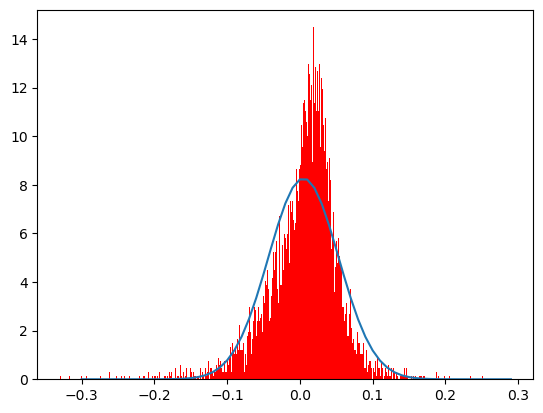

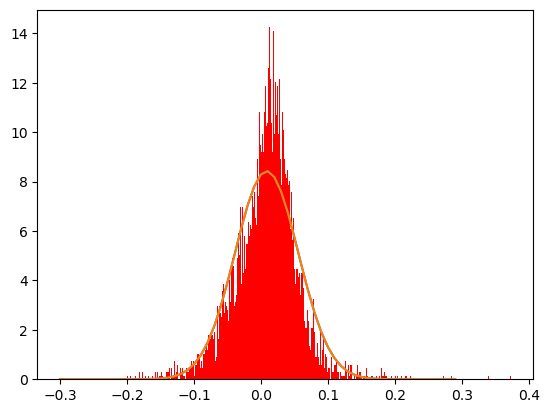

In [12]:
#use sklearn.preprocessing.PowerTransformer instead

plt.figure()

column_name = 'sp_20_dys'
column = not_null[column_name] 
column = column[~np.isnan(column)]
print(column)
# column += np.array([1 for i in range(len(column))])
# print(column)
plt.figure()
plt.hist(column , color = 'red', bins = 500, density=True)
mean = np.mean(column)
std = np.std(column)
print(mean)
print(std)
x_axis = np.arange(-.3, .3, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))


plt.figure()
plt.hist(yeojohnson(column)[0] , color = 'red', bins = 500, density=True)
mean = np.mean(yeojohnson(column)[0])
std = np.std(yeojohnson(column)[0])
print(mean)
print(std)
x_axis = np.arange(-.3, .3, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))
# plt.hist(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])) , color = 'red', bins = 500, density=True)
# mean = np.mean(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])))
# std = np.std(np.log(sp_not_null[column_name] + np.array([1 for i in range(len(sp_not_null[column_name]))])))



# column += np.array([1 for i in range(len(column))])
# column = np.log(column)
# plt.figure()
# plt.hist(yeojohnson(column)[0] , color = 'red', bins = 500, density=True)
# mean = np.mean(yeojohnson(column)[0])
# std = np.std(yeojohnson(column)[0])
# print(mean)
# print(std)
# x_axis = np.arange(-.3, .3, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, mean, std))
# plt.hist(sp_not_null['sp_fut_2wks'], color = 'red', bins = 500)
# plt.hist(sp_not_null['re_fut_2wks'], color = 'green', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['bnd_fut_2wks'], color = 'blue', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['gld_fut_2wks'], color = 'yellow', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['eu_fut_2wks'], color = 'green', bins = 500, alpha = .5,)
# plt.hist(sp_not_null['jp_fut_2wks'], color = 'blue', bins = 500, alpha = .5,)
plt.show()

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# ax.scatter(not_null["sp_last_month"], not_null["re_last_month"], not_null["re_sp_2wk_diff"])
# ax.set_xlabel('sp_last_month')
# ax.set_ylabel('re_last_month')
# ax.set_zlabel('re_sp_2wk_diff')
# plt.show()

In [14]:
def get_rvs(baseline, df, aliases, pred_distance):
    rvs = {}
    
    valid_cols = []
    for col in df.columns:
        if not col in aliases and col != "Date" and not "diff" in col and not "fut" in col:
            valid_cols.append(col)
    valid_cols.append(None)
    
    for asset in aliases:
        if asset != baseline:
            valid_cols[-1] = (asset + "_" + baseline + "_" + str(pred_distance) + "dys_diff")

            cov_mat = df[valid_cols]
            cov_matrix = pd.DataFrame.cov(cov_mat)
            cov_mat = cov_mat.cov()
            cov_mat = cov_mat.to_numpy()
            print(asset)
            print(cov_matrix)


            # means of values
            means = []
            for col in valid_cols:
                means.append(np.mean(df[col]))

            rv = multivariate_normal(mean=means, cov=cov_mat, allow_singular=True)
            rvs[asset] = rv
    return rvs
        


def predict(asset, baseline, rv, inputs, get_plots=False, do_print=False, get_50_pt = False):
    START = -.22
    STOP = .22
    INCREMENT = .00005

    probs = []
   
    x = np.arange(START, STOP, INCREMENT)
    inputs.append(None)
    for val in x:
        # make an array with all the current values
        # insert past month performance
        #"sp", "re", "bnd", "eu", "jp", "gld", future difference
        inputs[-1] = val
        probs.append(rv.pdf(inputs))


    cdf = []
    for idx in range(x.size - 1):
        cur_prob = probs[idx]
        next_prob = probs[idx + 1]
        rieman_sum = min(cur_prob, next_prob) * INCREMENT
        rieman_sum += max(cur_prob, next_prob) - min(cur_prob, next_prob) * INCREMENT / 2
        if len(cdf) > 0:
            cdf.append(rieman_sum + cdf[-1])
        else:
            cdf.append(rieman_sum)
                                 
    if get_plots:
        fig1 = plt.figure()
        ax = fig1.add_subplot(111)
        plt.title("pdf")
        plt.xlabel("difference between performance of " + asset + " and " + baseline)
        plt.ylabel("probability")
        ax.plot(x, probs/cdf[-1])
        plt.show()

    for idx in range(len(cdf)):
        cdf[idx] /= cdf[-1]

    if get_plots:
        fig2 = plt.figure()
        ax = fig2.add_subplot(111)
        plt.title("cdf")
        plt.xlabel("difference between performance of " + asset + " and " + baseline)
        plt.ylabel("probability")
        ax.plot(x[:-1], cdf)
        plt.show() 
        
    if get_50_pt:
        # find 50% point
        cur_prob = 0
        idx = 0
        while(cur_prob < .5):
            cur_prob = cdf[idx]
            idx += 1
        fiftyfiftypt = x[idx]
        if do_print:
            print("50 50 change to be above or below")
            print(x[idx])


    #find expected value
    expected_value = 0
    for idx in range(len(cdf)):
        if idx == 0:
            expected_value += cdf[idx] * x[idx]
        else:
            cur_prob = cdf[idx - 1]
            next_prob = cdf[idx]
            actual_prob = next_prob - cur_prob
            expected_value += actual_prob * x[idx]
                                 
    if do_print:
        print("Expected Value")
        print(expected_value)
                                 
    if get_50_pt:
        return fiftyfiftypt, expected_value
    else:
        return expected_value

In [15]:
rvs = get_rvs(baseline_asset, not_null, aliases, pred_distance)
# predict("bnd", baseline_asset, rvs, [-0.060534,0.015215,-0.030221,0.018300,-0.000830,-0.026808,-0.058842,0.000109,-0.021193,0.033956], get_plots=True)

re
                  sp_20_dys  re_20_dys    bnd_20_dys  eu_20_dys  jp_20_dys  \
sp_20_dys          0.002330  -0.000278  1.459552e-04   0.000058   0.000104   
re_20_dys         -0.000278   0.000761  2.347990e-04  -0.000520  -0.000069   
bnd_20_dys         0.000146   0.000235  7.522754e-04  -0.000472  -0.000151   
eu_20_dys          0.000058  -0.000520 -4.720374e-04   0.002270   0.000167   
jp_20_dys          0.000104  -0.000069 -1.513276e-04   0.000167   0.000158   
gld_20_dys         0.001749  -0.000061 -3.830879e-05   0.000448   0.000326   
sp_10_dys          0.001209  -0.000127  7.681667e-05  -0.000047   0.000067   
re_10_dys         -0.000157   0.000395  1.232644e-04  -0.000270  -0.000047   
bnd_10_dys         0.000077   0.000125  3.933759e-04  -0.000259  -0.000081   
eu_10_dys          0.000092  -0.000269 -2.367512e-04   0.001182   0.000107   
jp_10_dys          0.000041  -0.000025 -7.615969e-05   0.000067   0.000082   
gld_10_dys         0.000944   0.000014 -4.817039e-07   0.0002

In [16]:
def test_preds(assets, baseline, pred_distance, df):
    rvs = get_rvs(baseline, df, assets, pred_distance)
    preds = {}
    actuals = {}
    for asset in assets:
        if asset != baseline:
            preds[asset] = []
            actuals[asset] = []
    
    pred_columns = []
    for col_idx, col in enumerate(df.columns):
        if not col in aliases and col != "Date" and not "diff" in col and not "fut" in col:
            pred_columns.append(col_idx)
            
            
    print('start')
    for idx, row in df.iterrows():
        for asset in assets:
            if asset != baseline:
#                 print(asset)
                col_name = asset + "_" + baseline  + "_" + str(pred_distance) + "dys_diff"
                actual = row[col_name]
                actuals[asset].append(actual)
#                 print(actual)
                columns = []
                pred_input = df.iloc[idx, pred_columns]
                if not pred_input.isnull().any():
                    prediction = predict(asset, baseline, rvs[asset], pred_input.tolist(), get_plots=False)
                    preds[asset].append(prediction)
#                     print(prediction)
                else:
                    preds[asset].append(None)
#                     print(None)
#                 print("---------")
        if idx % 10== 0:
            print(idx)

    return preds, actuals            

In [17]:
preds, actuals = test_preds(aliases, baseline_asset, pred_distance, not_null)

re
                  sp_20_dys  re_20_dys    bnd_20_dys  eu_20_dys  jp_20_dys  \
sp_20_dys          0.002330  -0.000278  1.459552e-04   0.000058   0.000104   
re_20_dys         -0.000278   0.000761  2.347990e-04  -0.000520  -0.000069   
bnd_20_dys         0.000146   0.000235  7.522754e-04  -0.000472  -0.000151   
eu_20_dys          0.000058  -0.000520 -4.720374e-04   0.002270   0.000167   
jp_20_dys          0.000104  -0.000069 -1.513276e-04   0.000167   0.000158   
gld_20_dys         0.001749  -0.000061 -3.830879e-05   0.000448   0.000326   
sp_10_dys          0.001209  -0.000127  7.681667e-05  -0.000047   0.000067   
re_10_dys         -0.000157   0.000395  1.232644e-04  -0.000270  -0.000047   
bnd_10_dys         0.000077   0.000125  3.933759e-04  -0.000259  -0.000081   
eu_10_dys          0.000092  -0.000269 -2.367512e-04   0.001182   0.000107   
jp_10_dys          0.000041  -0.000025 -7.615969e-05   0.000067   0.000082   
gld_10_dys         0.000944   0.000014 -4.817039e-07   0.0002

                   sp_20_dys  re_20_dys    bnd_20_dys  eu_20_dys  jp_20_dys  \
sp_20_dys           0.002330  -0.000278  1.459552e-04   0.000058   0.000104   
re_20_dys          -0.000278   0.000761  2.347990e-04  -0.000520  -0.000069   
bnd_20_dys          0.000146   0.000235  7.522754e-04  -0.000472  -0.000151   
eu_20_dys           0.000058  -0.000520 -4.720374e-04   0.002270   0.000167   
jp_20_dys           0.000104  -0.000069 -1.513276e-04   0.000167   0.000158   
gld_20_dys          0.001749  -0.000061 -3.830879e-05   0.000448   0.000326   
sp_10_dys           0.001209  -0.000127  7.681667e-05  -0.000047   0.000067   
re_10_dys          -0.000157   0.000395  1.232644e-04  -0.000270  -0.000047   
bnd_10_dys          0.000077   0.000125  3.933759e-04  -0.000259  -0.000081   
eu_10_dys           0.000092  -0.000269 -2.367512e-04   0.001182   0.000107   
jp_10_dys           0.000041  -0.000025 -7.615969e-05   0.000067   0.000082   
gld_10_dys          0.000944   0.000014 -4.817039e-0

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [18]:
print(not_null.shape)

(5787, 52)


In [19]:
import pickle 

with open('preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

with open('actuals.pkl', 'wb') as f:
    pickle.dump(actuals, f)



In [49]:
sign_cor_neg = 0
sign_cor_pos = 0
incor_actual_neg = 0
incor_actual_pos = 0
total_diff = 0
total_count = 0
total_correct = 0

for pred, actual in zip(preds['re'], actuals['re']):
    if pred != None and not pd.isna(actual):
        if pred < 0 and actual < 0:
            sign_cor_neg += 1
            total_correct += 1
        elif pred > 0 and actual > 0:
            sign_cor_pos += 1
            total_correct += 1
        elif actual < 0:
            incor_actual_neg += 1
        else:
            incor_actual_pos +=1
        total_count += 1
        total_diff += abs(pred - actual)

In [50]:
print("pred neg actual neg")
print(sign_cor_neg)
print("pred pos actual pos")
print(sign_cor_pos)
print("pred pos actual neg")
print(incor_actual_neg) 
print("pred neg actual pos")
print(incor_actual_pos )

print("-----")
print("total neg")
print(sign_cor_neg + incor_actual_neg)
print("total pos")
print(sign_cor_pos + incor_actual_pos)
print("----")
print("ave diff")
print(total_diff/total_count)
print("percent correct")
print(total_correct/total_count)


pred neg actual neg
883
pred pos actual pos
340
pred pos actual neg
431
pred neg actual pos
581
-----
total neg
1314
total pos
921
----
ave diff
0.02638439354344783
percent correct
0.5472035794183445


In [128]:
total = 1
period_counts = 0
for pred, actual in zip(preds['eu'][::10], actuals['eu'][::10]):
    if pred != None and not pd.isna(actual):
        if pred > 0:
            total *= (1 + 10 * pred * actual)
        if pred < 0:
            total *= (1 + 10 * pred * -(actual))
        period_counts += 1
#         else:
#             total *= (1 + actual)
#         print(total)

print(total)
print(period_counts)

0.980100060068613
223
